# AdaBoost, GradientBoost, and XGBoost

In [32]:
import pandas as pd
import numpy as np
import pickle
import time

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, plot_confusion_matrix, confusion_matrix

from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE

from category_encoders import TargetEncoder

import warnings
warnings.filterwarnings('ignore')

In [11]:
X_train = pd.read_csv('Data/X_train.csv', index_col='building_id')
X_test = pd.read_csv('Data/X_test.csv', index_col='building_id')
y_train = pd.read_csv('Data/y_train.csv', index_col='building_id')
y_test = pd.read_csv('Data/y_test.csv', index_col='building_id')

In [12]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [22]:
#Create a dictionary and helper function to track model scores.
score_dict = {}
def print_scores():
    for key in score_dict.keys():
        print(f'{key},\t f1_micro_score: {round(score_dict[key][0],4)},\t Run time: {round(score_dict[key][1],0)}')

### Divide Columns and drop unimportant features

Let's start by dropping unimportant features and using target encdoing, which was our best approach with the Random Forest models.  Then we'll try untuned AdaBoost, GradientBoosting, and XGBoost, and see which performs best.

In [14]:
binary_cols = []
for col in X_train.columns:
    if col.startswith('has'):
        binary_cols.append(col)

cat_cols = list(X_train.select_dtypes(include='object').columns)

integer_cols = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

geo_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

all_cols = geo_cols + cat_cols + integer_cols + binary_cols

In [15]:
binary_cols_dropped = binary_cols.copy()
for col in binary_cols_dropped:
    if col.startswith('has_secondary'):
        binary_cols_dropped.remove(col)
binary_cols_dropped.append('has_secondary_use')

cat_cols_dropped = cat_cols.copy()
cat_cols_dropped.remove('legal_ownership_status')
cat_cols_dropped.remove('plan_configuration')

### AdaBoost Classifier

In [16]:
ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
target_pipe = imbPipeline([('target', TargetEncoder(cols=geo_cols))])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('integer', 'passthrough', integer_cols),
    ('geo', target_pipe, geo_cols)
])

In [56]:
adaboost0_pipe = imbPipeline([
    ('transformer', transformer),
    ('adaboost', AdaBoostClassifier(random_state=42))
])

In [19]:
start = time.time()
f1_micro_adaboost0 = cross_val_score(adaboost0_pipe, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_adaboost0 = end-start

Run time: 75.27919721603394


In [20]:
f1_micro_adaboost0 = f1_micro_adaboost0.mean()
f1_micro_adaboost0

0.718096699923254

In [23]:
score_dict['adaboost0'] = [f1_micro_adaboost0, run_time_adaboost0]
print_scores()

adaboost0,	 f1_micro_score: 0.7181,	 Run time: 75.0


Random Forest performs better than this model.  

### Gradient Boosting Classifier

In [57]:
gradientboost0_pipe = imbPipeline([
    ('transformer', transformer),
    ('gradient_boost', GradientBoostingClassifier(random_state=42))
])

In [25]:
start = time.time()
f1_micro_gradientboost0 = cross_val_score(gradientboost0_pipe, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_gradientboost0 = end-start

Run time: 793.0880649089813


In [26]:
f1_micro_gradientboost0 = f1_micro_gradientboost0.mean()
f1_micro_gradientboost0

0.7306369915579431

In [27]:
score_dict['gradientboost0'] = [f1_micro_gradientboost0, run_time_gradientboost0]
print_scores()

adaboost0,	 f1_micro_score: 0.7181,	 Run time: 75.0
gradientboost0,	 f1_micro_score: 0.7306,	 Run time: 793.0


Any improvment over AdaBoost, but at a significant runtime cost.

### XGBoost

In [58]:
XGBoost0_pipe = imbPipeline([
    ('transformer', transformer),
    ('xgboost', XGBClassifier(n_jobs=-1, random_state=42))
])

In [29]:
start = time.time()
f1_micro_XGBoost0 = cross_val_score(XGBoost0_pipe, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_XGBoost0 = end-start

Run time: 332.93079018592834


In [30]:
f1_micro_XGBoost0 = f1_micro_XGBoost0.mean()
f1_micro_XGBoost0

0.7375236633410078

In [31]:
score_dict['XGBoost0'] = [f1_micro_XGBoost0, run_time_XGBoost0]
print_scores()

adaboost0,	 f1_micro_score: 0.7181,	 Run time: 75.0
gradientboost0,	 f1_micro_score: 0.7306,	 Run time: 793.0
XGBoost0,	 f1_micro_score: 0.7375,	 Run time: 333.0


XGBoost is the best performer, outscoring GradientBoost in less than half the time.  Let's move on to tuning.  

### Try using a smaller train set for tuning

Due to limited computational resources, I'm going to tune the model on only a sample of training data.  I'll also use Google Colab to run a more expansive gridsearch and then do a more narrowed search on my local machine.

In [46]:
X_train_sample, X_train_leftover, y_train_sample, y_train_leftover = \
    train_test_split(X_train, y_train, test_size=.9, random_state=42)

In [59]:
XGBoost_sample_pipe = imbPipeline([
    ('transformer', transformer),
    ('xgboost', XGBClassifier(n_jobs=-1, random_state=42))
])

In [53]:
start = time.time()
f1_micro_XGBoost_sample = cross_val_score(XGBoost_sample_pipe, X_train_sample, y_train_sample, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_XGBoost_sample = end-start

Run time: 64.49462294578552


In [54]:
f1_micro_XGBoost_sample = f1_micro_XGBoost_sample.mean()
f1_micro_XGBoost_sample

0.683141468406242

In [55]:
score_dict['XGBoost_sample'] = [f1_micro_XGBoost_sample, run_time_XGBoost_sample]
print_scores()

adaboost0,	 f1_micro_score: 0.7181,	 Run time: 75.0
gradientboost0,	 f1_micro_score: 0.7306,	 Run time: 793.0
XGBoost0,	 f1_micro_score: 0.7375,	 Run time: 333.0
XGBoost1,	 f1_micro_score: 0.6831,	 Run time: 61.0
XGBoost_sample,	 f1_micro_score: 0.6831,	 Run time: 64.0


### GridSearchCV

In [60]:
start = time.time()
XGBoost_param_grid = {'xgboost__max_depth': [3, 6, 10],
                      'xgboost__learning_rate': [.01, .05, .3, .4],
                      'xgboost__subsample': [.3, .5, 1]}

XGBoost_gs = GridSearchCV(estimator=XGBoost_sample_pipe, param_grid=XGBoost_param_grid, 
                          scoring='f1_micro', cv=3, n_jobs=-1, verbose=2)
XGBoost_gs.fit(X_train, y_train)
end = time.time()
print(f'Run time: {end-start}')

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 104.9min finished


Run time: 6457.740588188171


In [62]:
XGBoost_gs.best_params_

{'xgboost__learning_rate': 0.4,
 'xgboost__max_depth': 6,
 'xgboost__subsample': 1}

In [63]:
XGBoost_gs.best_score_

0.7356254796623176

## XGBoost1:  Use the gridsearched hyperparameters on the full X_train

In [64]:
XGBoost1_pipe = imbPipeline([
    ('transformer', transformer),
    ('xgboost', XGBClassifier(learning_rate=.4, max_depth=6, subsample=1, n_jobs=-1, random_state=42))
])

In [65]:
start = time.time()
f1_micro_XGBoost1 = cross_val_score(XGBoost1_pipe, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_XGBoost1 = end-start

Run time: 666.7010850906372


In [66]:
f1_micro_XGBoost1 = f1_micro_XGBoost1.mean()
f1_micro_XGBoost1

0.7383985674085444

In [67]:
score_dict['XGBoost1'] = [f1_micro_XGBoost1, run_time_XGBoost1]
print_scores()

adaboost0,	 f1_micro_score: 0.7181,	 Run time: 75.0
gradientboost0,	 f1_micro_score: 0.7306,	 Run time: 793.0
XGBoost0,	 f1_micro_score: 0.7375,	 Run time: 333.0
XGBoost1,	 f1_micro_score: 0.7384,	 Run time: 667.0
XGBoost_sample,	 f1_micro_score: 0.6831,	 Run time: 64.0


The tuned XGBoost model performs slightly better than the untuned one.  Let's now make predictions on the test set and calculate the f1-micro score to compare to the other finished models.

### Checking the final model's performance on the test set

In [68]:
XGBoost1_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('binary', 'passthrough',
                                                  ['has_superstructure_adobe_mud',
                                                   'has_superstructure_mud_mortar_stone',
                                                   'has_superstructure_stone_flag',
                                                   'has_superstructure_cement_mortar_stone',
                                                   'has_superstructure_mud_mortar_brick',
                                                   'has_superstructure_cement_mortar_brick',
                                                   'has_superstructure_timber',
                                                   'has_superstr...
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.4,
                               max_delta_step=0, max_depth=6,
                 

In [69]:
XGBoost1_preds = XGBoost1_pipe.predict(X_test)
XGBoost1_test_score = f1_score(y_test, XGBoost1_preds, average='micro')
XGBoost1_test_score

0.7445319335083116

The model performs comparably to the best Random Forest model.  

### Plot confusion matrix and check model's target accuracies

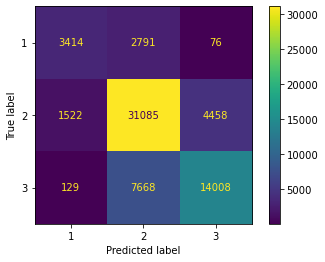

In [70]:
plot_confusion_matrix(XGBoost1_pipe, X_test, y_test);

In [71]:
cm = confusion_matrix(y_test, XGBoost1_preds)
low_damage = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
medium_damage = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
complete_destruction = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
print(f'The model correctly predicts {round(low_damage*100, 2)}% of low damage.')
print(f'The model correctly predicts {round(medium_damage*100, 2)}% of medium damage.')
print(f'The model correctly predicts {round(complete_destruction*100, 2)}% of complete destruction.')

The model correctly predicts 54.35% of low damage.
The model correctly predicts 83.87% of medium damage.
The model correctly predicts 64.24% of complete destruction.


### Export the model.

In [73]:
with open ('../Models/XGBoost1.pickle', 'wb') as f:
    pickle.dump(XGBoost1_pipe, f, pickle.HIGHEST_PROTOCOL)